In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Load the data

In [2]:
from tensorflow.keras.datasets import cifar10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170500096/170498071 [==============================] - 6s 0us/step


In [3]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


Data Visualization

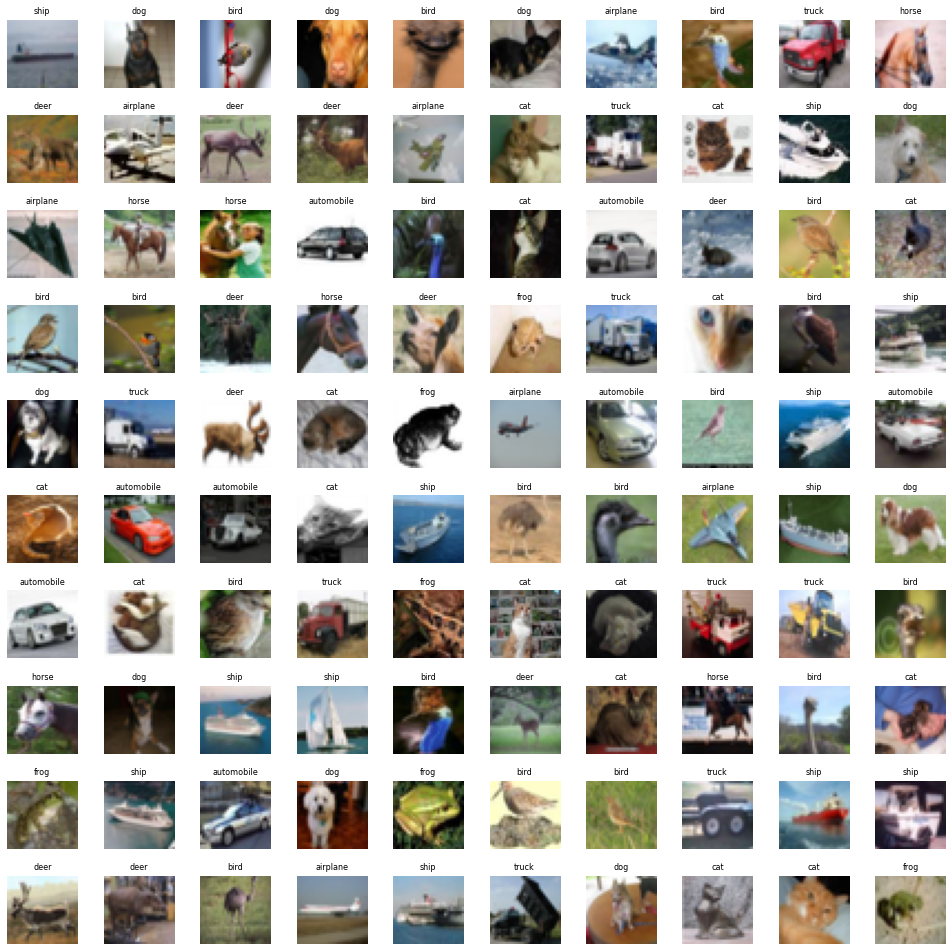

In [4]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Let's view more images in a grid format
# Define the dimensions of the plot grid 
W_grid = 10
L_grid = 10

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_train = len(X_train) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_train)
    # read and display an image with the selected index    
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Text(0.5, 1.0, 'Class distribution in training set')

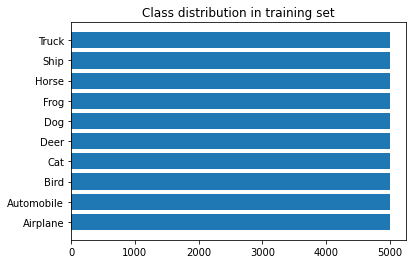

In [5]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in training set')

Text(0.5, 1.0, 'Class distribution in testing set')

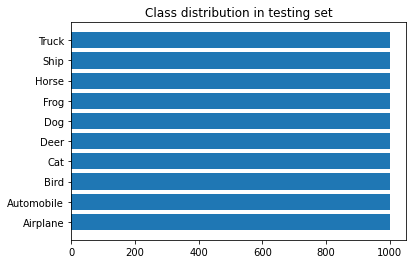

In [6]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

The class are equally distributed

Data Preprocessing

In [7]:
# Scale the data
X_train = X_train / 255
X_test = X_test / 255

In [8]:
from tensorflow.keras.utils import to_categorical

In [9]:
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [10]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

Model Building

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization

In [12]:
model = Sequential()
# Convolutional Layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
# Pooling layer
model.add(MaxPool2D(pool_size=(2, 2)))
# Dropout layers
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        1

## Early Stopping

In [14]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2)

Data Augmentations

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [16]:
r = model.fit(train_generator, 
              epochs=200,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test)
             )

Epoch 1/200
1562/1562 [==============================] - 40s 15ms/step - loss: 1.9207 - accuracy: 0.3229 - precision: 0.5063 - recall: 0.1177 - val_loss: 1.4705 - val_accuracy: 0.4936 - val_precision: 0.6234 - val_recall: 0.3563
Epoch 2/200
1562/1562 [==============================] - 23s 15ms/step - loss: 1.3096 - accuracy: 0.5300 - precision: 0.7131 - recall: 0.3535 - val_loss: 1.3865 - val_accuracy: 0.5342 - val_precision: 0.6412 - val_recall: 0.4408
Epoch 3/200
1562/1562 [==============================] - 23s 15ms/step - loss: 1.0917 - accuracy: 0.6181 - precision: 0.7647 - recall: 0.4707 - val_loss: 1.0138 - val_accuracy: 0.6652 - val_precision: 0.7673 - val_recall: 0.5527
Epoch 4/200
1562/1562 [==============================] - 23s 15ms/step - loss: 0.9673 - accuracy: 0.6665 - precision: 0.7857 - recall: 0.5400 - val_loss: 1.0606 - val_accuracy: 0.6455 - val_precision: 0.7422 - val_recall: 0.5625
Epoch 5/200
1562/1562 [==============================] - 23s 15ms/step - loss: 0.882

Model Evaluation

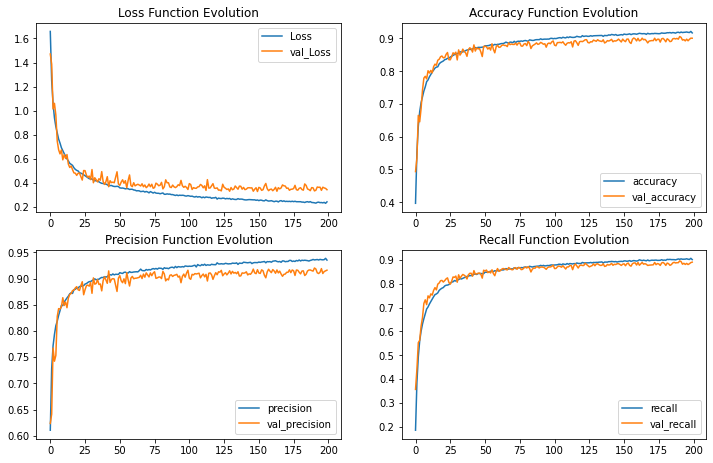

In [17]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

In [18]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

313/313 [==============================] - 1s 3ms/step - loss: 0.3426 - accuracy: 0.9007 - precision: 0.9159 - recall: 0.8914
Test Accuracy : 90.07%


In [19]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict_classes(X_test)

cm = confusion_matrix(y_test, y_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91      1000
           1       0.93      0.97      0.95      1000
           2       0.87      0.87      0.87      1000
           3       0.84      0.75      0.79      1000
           4       0.87      0.92      0.90      1000
           5       0.87      0.83      0.85      1000
           6       0.88      0.95      0.92      1000
           7       0.95      0.93      0.94      1000
           8       0.91      0.96      0.93      1000
           9       0.94      0.92      0.93      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



## Test on one image

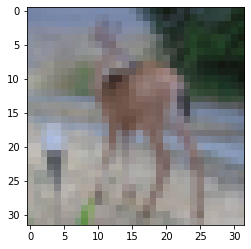

In [22]:
my_image = X_test[100]
plt.imshow(my_image)

In [23]:
# that's a Deer
y_test[100]

array([4], dtype=uint8)

In [24]:
# correctly predicted as a Deer
model.predict_classes(my_image.reshape(1, 32, 32, 3))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([4])

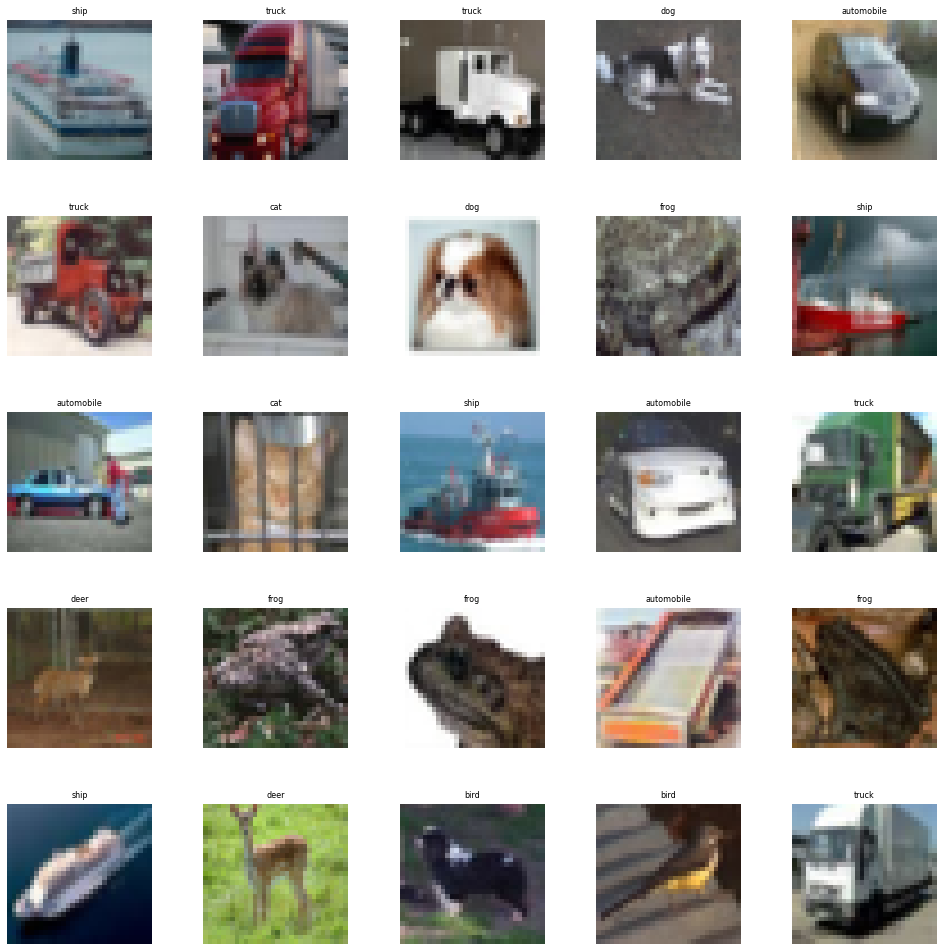

In [25]:
# Define the labels of the dataset
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']
W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

n_test = len(X_test) # get the length of the train dataset

# Select a random number from 0 to n_train
for i in np.arange(0, W_grid * L_grid): # create evenly spaces variables 

    # Select a random number
    index = np.random.randint(0, n_test)
    # read and display an image with the selected index    
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [26]:
predictions = model.predict(X_test)

In [27]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

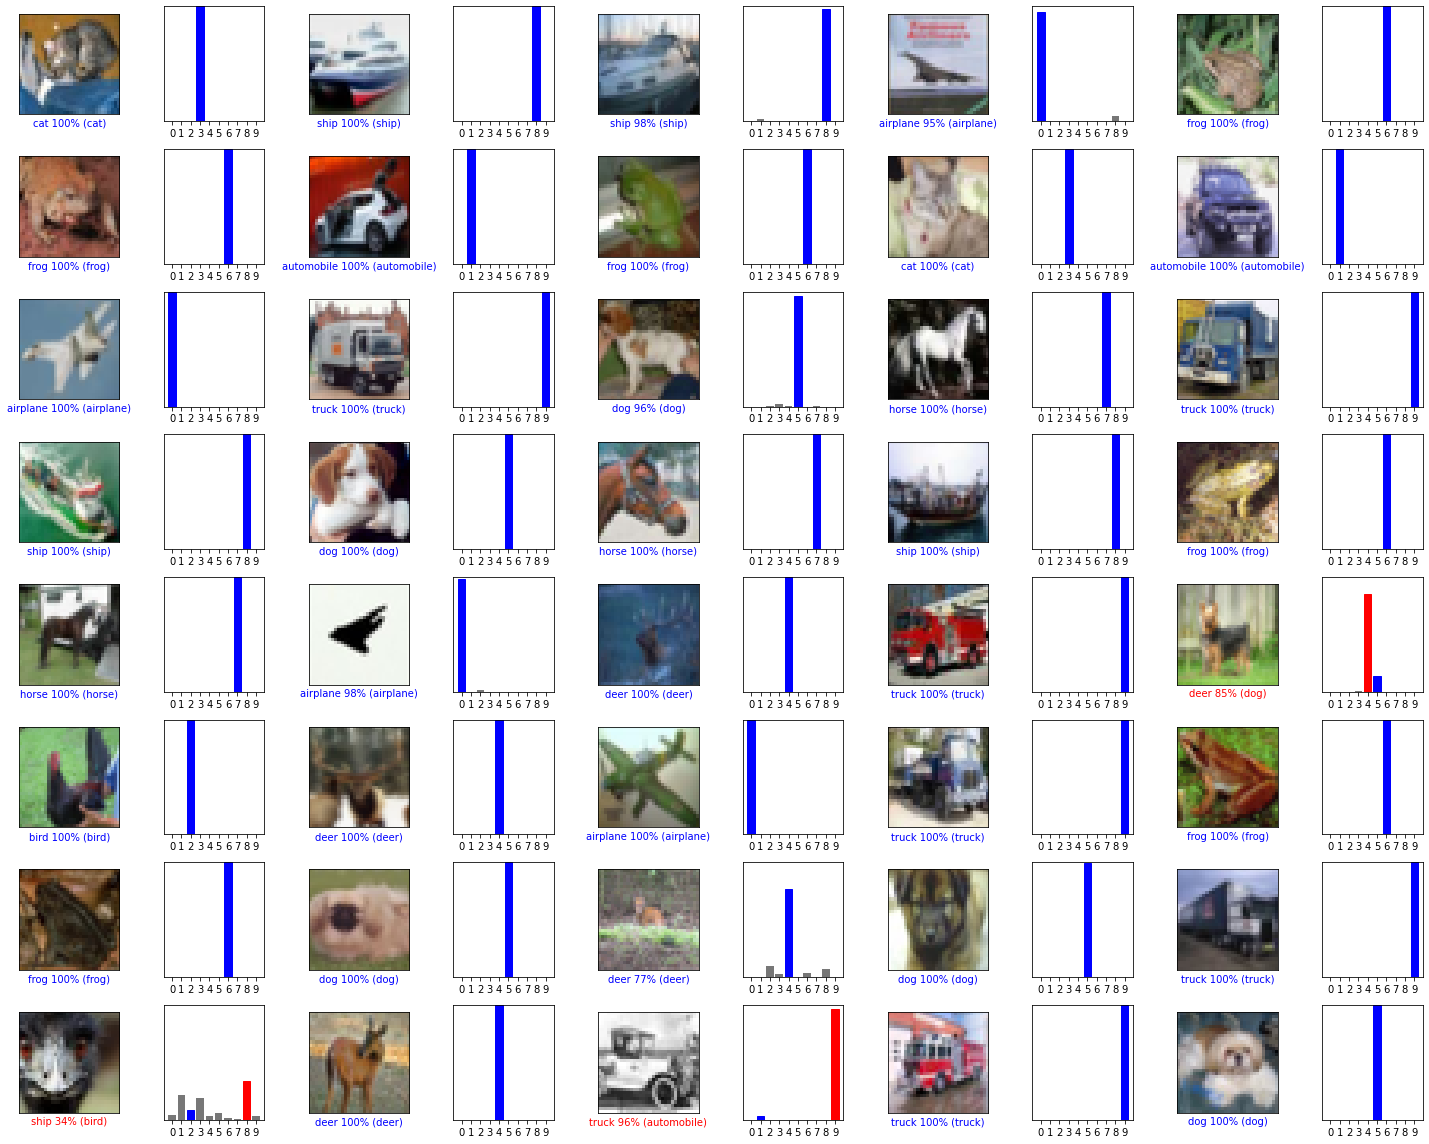

In [28]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

In [29]:
from tensorflow.keras.models import load_model

model.save('cnn_20_epochs.h5')